In [1]:
import duckdb
import pandas as pd
import statsmodels.formula.api as smf
from debugpy.common.util import evaluate
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load design matrix from gold schema

Transformations and preparation done in `dbt` project.

In [2]:
data_dir = '../data/ppp_loan_analysis.duckdb'
with duckdb.connect(data_dir) as conn:
    query = """
        SELECT * EXCLUDE (ppp_loan_amount, total_annual_wages)
        FROM gold.wage_adjusted_ppp_target
    """
    df = conn.execute(query).df()
    
df_clean = df.dropna()
assert len(df) == len(df_clean), 'Design matrix has missing values to remove'
df.head()

,county,state,urbanicity,yoy_job_change_pct,wage_adjusted_ppp_loan_amount,white_pop_share,black_pop_share,asian_pop_share,native_pop_share,hispanic_share,...,retail_trade_wage_share,retail_trade_job_loc_quotient,transportation_and_warehousing_wage_share,transportation_and_warehousing_job_loc_quotient,unclassified_wage_share,unclassified_job_loc_quotient,utilities_wage_share,utilities_job_loc_quotient,wholesale_trade_wage_share,wholesale_trade_job_loc_quotient
0,Appomattox County,Virginia,urban,-0.016036,0.172092,0.786940,0.185469,0.003834,0.003520,0.018855,...,0.225276,1.94,0.000000,0.00,0.003127,2.79,0.000000,0.00,0.036170,0.47
1,Arlington County,Virginia,urban,0.026394,0.059148,0.750032,0.096782,0.109546,0.007769,0.156015,...,0.024007,0.49,0.064589,1.40,0.001434,1.60,0.011543,0.53,0.017317,0.22
2,Giles County,Virginia,urban,-0.025776,0.069858,0.962739,0.015969,0.005801,0.002990,0.018361,...,0.103267,1.30,0.019956,0.41,0.001315,1.50,0.000000,0.00,0.000000,0.00
3,Grayson County,Virginia,rural,0.121393,0.160522,0.924823,0.057428,0.002058,0.003601,0.038264,...,0.057088,0.51,0.015953,0.23,0.000000,0.00,0.000000,0.00,0.000000,0.00
4,Richmond County,Virginia,rural,-0.001100,0.170235,0.667516,0.296465,0.007093,0.006096,0.072925,...,0.074205,0.79,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.074327,1.13


## Evaluate correlations of numerical variables

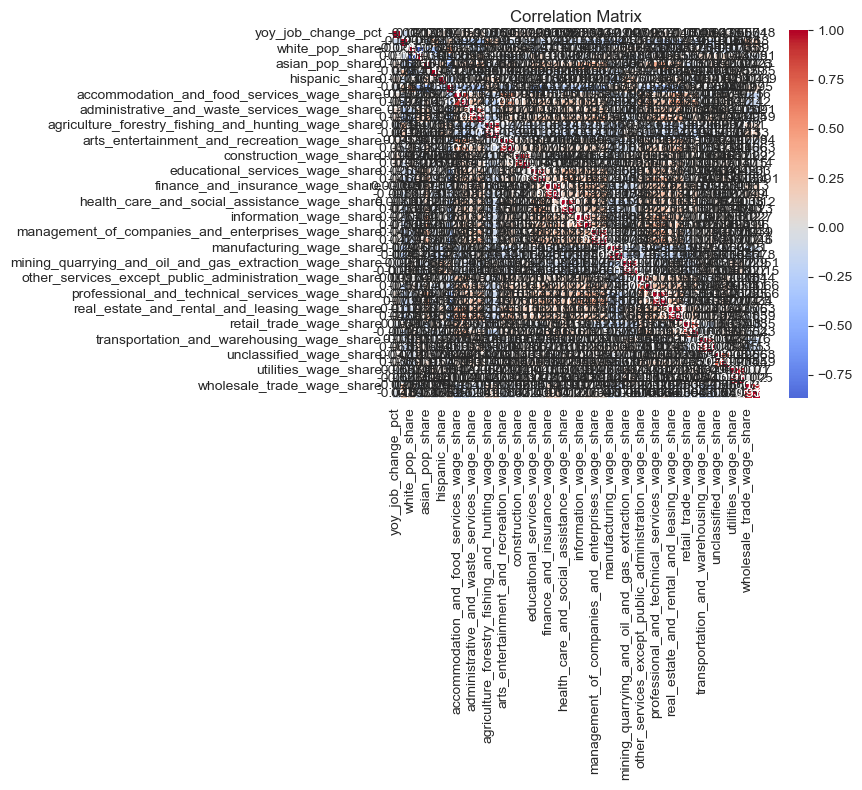

In [3]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

## Evaluate regression on all features

In [4]:
formula = f"np.log(wage_adjusted_ppp_loan_amount) ~ black_pop_share + white_pop_share + asian_pop_share + hispanic_share + trump_share + C(urbanicity, Treatment(reference='urban'))"
model1 = smf.ols(formula, data=df).fit()
print(model1.summary())

                                      OLS Regression Results                                     
Dep. Variable:     np.log(wage_adjusted_ppp_loan_amount)   R-squared:                       0.236
Model:                                               OLS   Adj. R-squared:                  0.235
Method:                                    Least Squares   F-statistic:                     136.7
Date:                                   Wed, 23 Jul 2025   Prob (F-statistic):          6.25e-176
Time:                                           22:18:50   Log-Likelihood:                -2100.0
No. Observations:                                   3102   AIC:                             4216.
Df Residuals:                                       3094   BIC:                             4264.
Df Model:                                              7                                         
Covariance Type:                               nonrobust                                         
                    

## Model evaluation and quality checks

Evaluate multi-collinearity for potential removal of features and then evaluate model assumptions, in light of high Kurtosis, suggesting that residuals may not follow a normal distribution. 

### Inspect multi-collinearity

In [5]:
def evaluate_vifs(model):
    dataframe = pd.DataFrame(model.model.exog, columns=model.model.exog_names)
    
    # Define the predictor variables
    X = dataframe.select_dtypes(include=[np.number])
    
    # Add a constant to the model (intercept)
    X = add_constant(X)
    
    # Calculate VIF for each feature
    datacamp_vif_data = pd.DataFrame()
    datacamp_vif_data['Feature'] = X.columns
    datacamp_vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(datacamp_vif_data)

evaluate_vifs(model1)

                                             Feature         VIF
0                                          Intercept  201.012900
1  C(urbanicity, Treatment(reference='urban'))[T....    1.430149
2  C(urbanicity, Treatment(reference='urban'))[T....    1.368635
3                                    black_pop_share    4.861694
4                                    white_pop_share    5.334022
5                                    asian_pop_share    1.531609
6                                     hispanic_share    1.087885
7                                        trump_share    1.753103


bp_stat: 93.64568675030944 | bp_pvalue: 2.2027648145219955e-17


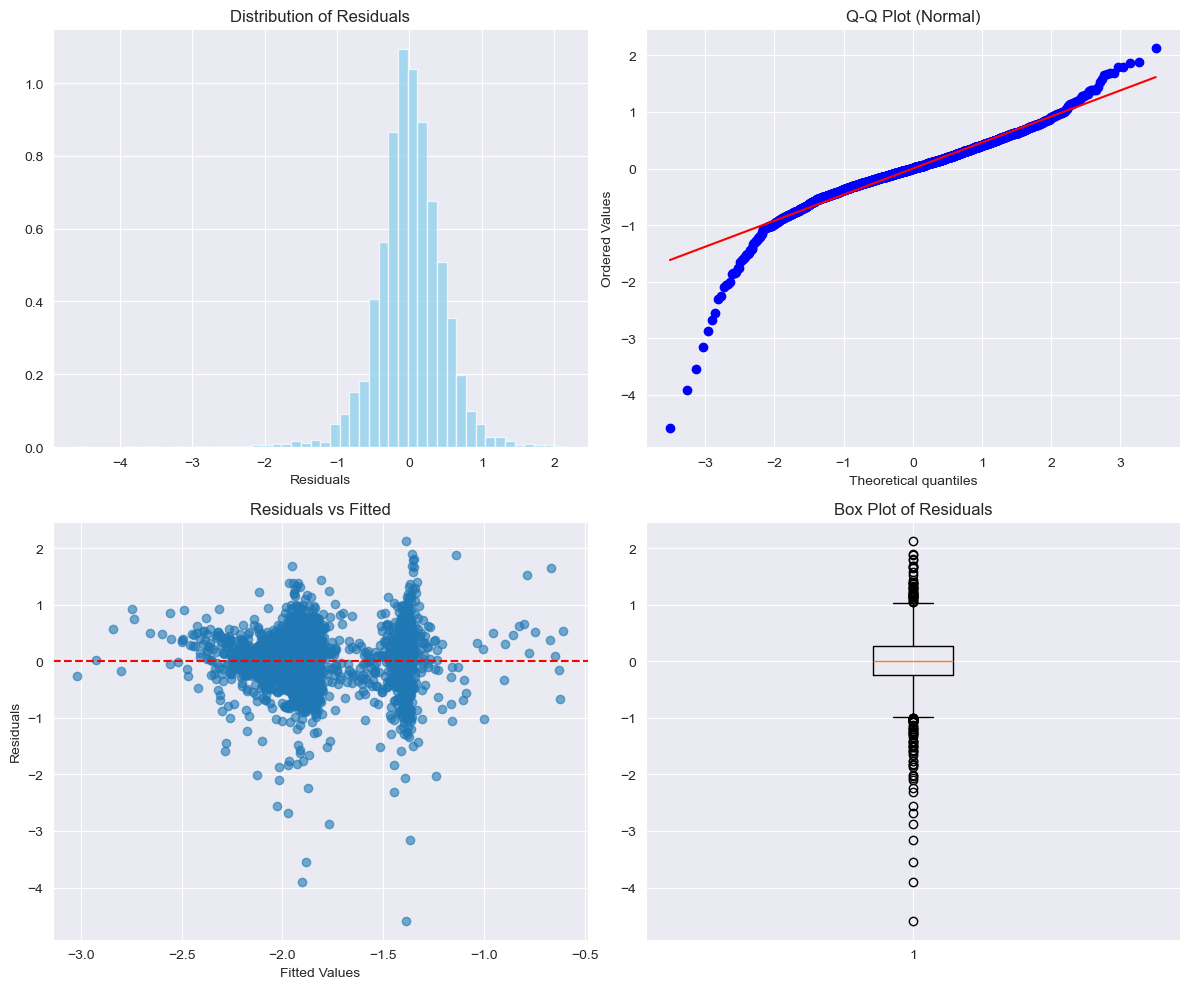

In [6]:
def test_model_assumptions(model):
    # Get residuals from your model
    residuals = model.resid
    
    X_design = model.model.exog
    bp_stat, bp_pvalue, _, _ = het_breuschpagan(model.resid, X_design)
    print(f'bp_stat: {bp_stat} | bp_pvalue: {bp_pvalue}')
    
    # Create diagnostic plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Histogram
    axes[0, 0].hist(residuals, bins=50, density=True, alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Distribution of Residuals')
    axes[0, 0].set_xlabel('Residuals')
    
    # 2. Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title('Q-Q Plot (Normal)')
    
    # 3. Residuals vs Fitted
    fitted = model.fittedvalues
    axes[1, 0].scatter(fitted, residuals, alpha=0.6)
    axes[1, 0].axhline(y=0, color='red', linestyle='--')
    axes[1, 0].set_xlabel('Fitted Values')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Residuals vs Fitted')
    
    # 4. Box plot
    axes[1, 1].boxplot(residuals)
    axes[1, 1].set_title('Box Plot of Residuals')
    
    plt.tight_layout()
    plt.show()

test_model_assumptions(model1)

## Model interpretation

R^2 and Adj. R^2 show strong descriptive power, but explore additional features to better capture PPP lending trends.

### VIF
From p-values, feature `black_pop_share` can be removed, reinforced by VIF computation. Kurtosis of ~8.8 indicates heteroscedacity should be checked, to question linear regression assumptions before proceeding with default standard errors.

### Model assumptions
Breusch Pagan p value Q-Q and residuals v. fitted plots show model does not meet linear regression assumptions and that other standard errors should be explored, such as HC3.   

## Revise model from assumptions

In [7]:
formula = f"np.log(wage_adjusted_ppp_loan_amount) ~ yoy_job_change_pct + white_pop_share + asian_pop_share + hispanic_share + trump_share + C(urbanicity, Treatment(reference='urban'))"
model2 = smf.ols(formula, data=df).fit(cov_type='HC3')
print(model2.summary())

                                      OLS Regression Results                                     
Dep. Variable:     np.log(wage_adjusted_ppp_loan_amount)   R-squared:                       0.225
Model:                                               OLS   Adj. R-squared:                  0.223
Method:                                    Least Squares   F-statistic:                     88.91
Date:                                   Wed, 23 Jul 2025   Prob (F-statistic):          2.36e-118
Time:                                           22:18:51   Log-Likelihood:                -2123.4
No. Observations:                                   3102   AIC:                             4263.
Df Residuals:                                       3094   BIC:                             4311.
Df Model:                                              7                                         
Covariance Type:                                     HC3                                         
                    

### Evaluate new model

                                             Feature        VIF
0                                          Intercept  39.618445
1  C(urbanicity, Treatment(reference='urban'))[T....   1.406379
2  C(urbanicity, Treatment(reference='urban'))[T....   1.365666
3                                 yoy_job_change_pct   1.015399
4                                    white_pop_share   1.428798
5                                    asian_pop_share   1.297332
6                                     hispanic_share   1.086985
7                                        trump_share   1.749029
bp_stat: 105.48642447206448 | bp_pvalue: 7.914625639516707e-20


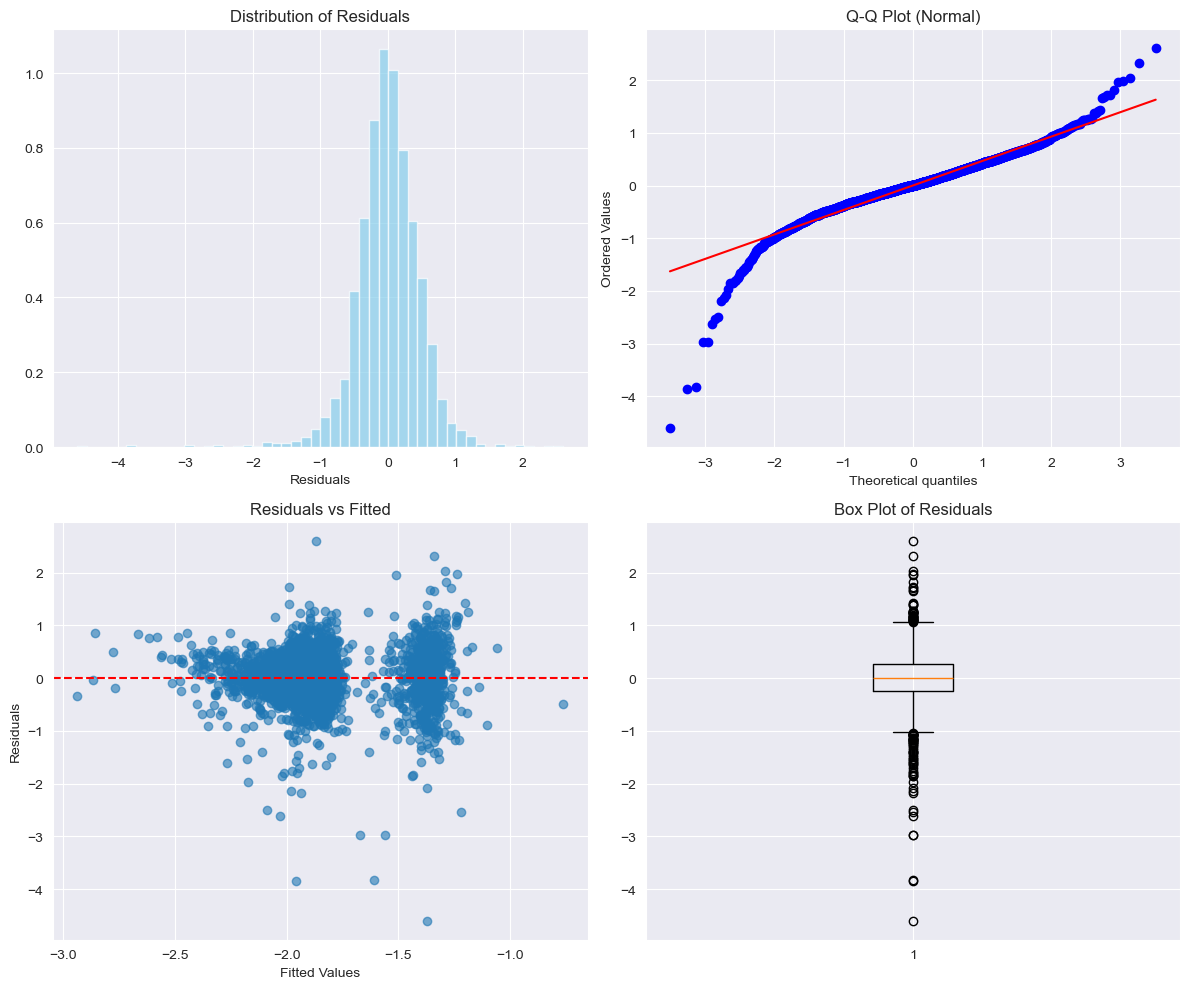

In [8]:
evaluate_vifs(model2)
test_model_assumptions(model2)

In [9]:
working_summary = model2.summary()
working_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     np.log(wage_adjusted_ppp_loan_amount)   R-squared:                       0.225
Model:                                               OLS   Adj. R-squared:                  0.223
Method:                                    Least Squares   F-statistic:                     88.91
Date:                                   Wed, 23 Jul 2025   Prob (F-statistic):          2.36e-118
Time:                                           22:18:51   Log-Likelihood:                -2123.4
No. Observations:                                   3102   AIC:                             4263.
Df Residuals:                                       3094   BIC:                             4311.
Df Model:                                              7                                         
Covariance Type:                                     HC3                                         
===========================================================================================================================
                                                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                  -1.8847      0.071    -26.569      0.000      -2.024      -1.746
C(urbanicity, Treatment(reference='urban'))[T.rural]        0.5462      0.033     16.581      0.000       0.482       0.611
C(urbanicity, Treatment(reference='urban'))[T.suburban]     0.0782      0.020      3.925      0.000       0.039       0.117
yoy_job_change_pct                                         -0.8090      0.342     -2.365      0.018      -1.480      -0.138
white_pop_share                                            -0.1997      0.073     -2.734      0.006      -0.343      -0.057
asian_pop_share                                            -2.2761      0.509     -4.473      0.000      -3.274      -1.279
hispanic_share                                             -0.3765      0.072     -5.242      0.000      -0.517      -0.236
trump_share                                                 0.2453      0.076      3.208      0.001       0.095       0.395
==============================================================================
Omnibus:                      840.889   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9311.174
Skew:                          -0.963   Prob(JB):                         0.00
Kurtosis:                      11.266   Cond. No.                         60.2
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

# Conclusion

## Summary
Urbanicity, racial makeup and 2016 election results held modest explanatory power for the distribution of Paycheck Protection Program loans by county, with an adjusted R^2 of `0.223`. The PPP amounts were adjusted by the size of local payrolls, taken from QCEW baselines for 2019.

The model showed rural areas were strongly favored to receive more wage-adjusted PPP dollars, in addition to some concerning trends by racial makeup that indicate concern of bias within the program. 

### Bias concerns
Within this limited explanation, the strongest association raises concerns about bias in the program and aligns, troublingly, with anti-Asian bias in response to the pandemic that began in Wuhan, China. This assocation warrants further investigation to evaluate additional county-level characteristics or to view this relationship in the context of a model with greater explanatory power.

The model also shows that higher percentages of Hispanic residents were associated with lower amounts of wage-adjusted PPP loan amounts.

Also of concern, the vote share for President Donald Trump also showed a relationship to higher totals of wage-adjusted PPP loans, suggesting that political favoritism may have affected use of the program.  